## Model Input:
- Sequential features: batchsize * 60 * 17
- MTF along features: batchsize * 31 * 31
- Non-sequential Features: batchsize * 14

### Attention Mechanism is applied in this model

## Import data

In [1]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,concatenate,LSTM,Input,Bidirectional,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras_self_attention import SeqSelfAttention
from keras import backend as K
import keras
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from fetch_data import get, get_KS


Using TensorFlow backend.


In [2]:
# In order to run the model on GPU, we need to enable memory growth for only one GPU.
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
with open(data_dir+'label.json') as f:
    labels = json.load(f)
with open(data_dir+'non_sequential_features.json') as f:
    non_sequential_features = json.load(f)
with open(data_dir+'padded_sequential_features_3.json') as f:
    sequential_features = json.load(f)
with open(data_dir+'featurematrix.json') as f:
    arr_ = json.load(f)
arr_ = np.array(arr_)

## Preprocessing

In [4]:
feature1 = np.array([sequential_features[key]
                     for key in sequential_features.keys()])
feature2 = np.array([non_sequential_features[key]
                     for key in non_sequential_features.keys()])
label = np.array([labels[key] for key in labels.keys()])

In [5]:
arr_.shape,feature1.shape,feature2.shape,label.shape

((3715, 31, 31), (3715, 60, 18), (3715, 14), (3715,))

In [6]:
arr_ = arr_.reshape(-1, 31, 31, 1)
feature1 = feature1[:, :, 1:]

X_train_arr, X_test_arr, X_train_f1, X_test_f1, X_train_f2, X_test_f2, y_train, y_test = train_test_split(arr_, feature1, feature2, label,
                                                                                                          test_size=0.20, random_state=42)


X_train_arr.shape, X_train_f1.shape, X_train_f2.shape, y_train.shape

((2972, 31, 31, 1), (2972, 60, 17), (2972, 14), (2972,))

## Model Building

In [7]:
# Input1: MTF along features, shape=batchsize*31*31*1
input_fm = Input(shape=(31, 31, 1), name="cnn_input")
fm = BatchNormalization()(input_fm)
cnn1 = Conv2D(16, (3, 3), padding="same", activation='relu')(fm)
bn1 = BatchNormalization()(cnn1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2)(bn1)
pool1 = Dropout(0.5)(pool1)
cnn2 = Conv2D(8, (3, 3), padding="same", activation='relu')(pool1)
bn2 = BatchNormalization()(cnn2)
pool2 = AveragePooling2D(pool_size=(2, 2), strides=2)(bn2)
pool2 = Dropout(0.5)(pool2)
cnn3 = Conv2D(1, (3, 3), padding="same", activation='relu')(pool2)
fm_output = Flatten()(cnn3)


# Input2: sequential features, shape= batchsize*60*17
input_rnn = Input(shape=(60, 17), name="rnn_input")
rnn = BatchNormalization()(input_rnn)
lstm1 = Bidirectional(LSTM(32, activation='tanh', return_sequences=True))(rnn)
lstm1 = SeqSelfAttention(attention_width=10, attention_activation='tanh')(lstm1)
lstm1 = Dropout(0.25)(lstm1)
rnn_output = Bidirectional(
    LSTM(1, activation='tanh', return_sequences=False))(lstm1)
# rnn_output=Flatten()(rnn_output)

# Input3: non-sequential features(user type and application time), shape=batchsize*14
input_non_sequential = Input(shape=(14,), name="dense_input")
non_sequential = BatchNormalization()(input_rnn)
dense1 = Dense(64, activation="relu")(input_non_sequential)
bn3 = BatchNormalization()(dense1)
drop2 = Dropout(0.25)(bn3)
dense2_output = Dense(32, activation="relu")(drop2)

# Merge the above models
merged = concatenate([fm_output, rnn_output, dense2_output])
merged = BatchNormalization()(merged)
dense3 = Dense(128, activation="relu")(merged)
bn4 = BatchNormalization()(dense3)
drop3 = Dropout(0.2)(bn4)
dense4 = Dense(64, activation="relu")(drop3)
bn5 = BatchNormalization()(dense4)
drop4 = Dropout(0.2)(bn5)
out = Dense(1, activation='sigmoid', name='output_layer')(drop4)

model = Model(inputs=[input_fm, input_rnn,
                      input_non_sequential], outputs=[out])
model.summary()


ada = optimizers.Adam(learning_rate=0.0002)
model.compile(loss='binary_crossentropy', optimizer=ada, metrics=[
              'accuracy', metrics.AUC()])  # optimizer='rmsprop'
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2)

model.fit([X_train_arr, X_train_f1, X_train_f2], [y_train],
          epochs=200, batch_size=1024,
          class_weight={0: 1., 1: 3},
          shuffle=True,
          validation_split=0.3,
          callbacks=[early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 31, 31, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 31, 31, 1)    4           cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 16)   160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 31, 31, 16)   64          conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
model.save("../../data/models/binary_classification_model/"+"multi_source_classifier_ks_point1487.h5")

## Model evaluation

In [9]:
prediction=model.predict([X_test_arr,X_test_f1,X_test_f2])

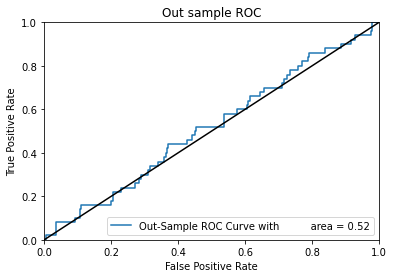

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
(fpr, tpr, thresholds) = roc_curve(y_test,prediction)
area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with \
         area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC')
plt.legend(loc="lower right")
plt.show()

- auc=0.59

In [11]:
def get_KS(y_prob,y_true):
    fpr,tpr,threshold=roc_curve(y_true,y_prob)
    ks=(tpr-fpr)
    max_=np.argmax(ks)
    
    return threshold[max_],np.max(ks)
get_KS(prediction,y_test)

(0.503213, 0.0705916305916306)

- ks=0.1487, corresponding threshold=0.17198